In [1]:
%load_ext autoreload
%autoreload 2
%cd "python/LatentEvolution"
%ls

/home/hew/python/LatentEvolution
cache/  data/  env.txt  figure/  framework/  main.py  script/  temp/


In [2]:


import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch
from scipy.stats import pearsonr
from sklearn.manifold import TSNE

from framework.utils.lightning.trainer_utils import LitInference
from script.task_02_ProteinVAE.ProteinVAE.sequence_data_module import SequenceDataModule
from script.task_02_ProteinVAE.ProteinVAE.sequence_lightning_module import SequenceLightningModule

========== add root_path and framework_path to sys.path ==========
root_path: /home/hew/python/LatentEvolution
framework_path: /home/hew/python/LatentEvolution/framework


In [3]:
log_dir = "./script/task_02_ProteinVAE/lightning_logs/"

# WAE
version = 0
epoch = '95, loss=36.179, ce=19.700, reg=10.850, mse=5.629, ddG=0.563, dS=0.858.ckpt'

In [4]:
inferencer = LitInference(SequenceLightningModule, SequenceDataModule, log_dir, version, epoch)
inferencer.set_batch_size(128)
tokenizer = inferencer.pl_data_module.tokenizer
model = inferencer.model.eval()
model

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Global seed set to 42


============================== PeptideDataModule __init__ Start ==============================
============================== PeptideDataModule __init__ End ==============================


ProteinVAE(
  (encoder_transformer): ESMTransformer(
    (embed_tokens): Embedding(33, 128, padding_idx=1)
    (layers): ModuleList(
      (0-3): 4 x TransformerLayer(
        (self_attn): MultiheadAttention(
          (k_proj): Linear(in_features=128, out_features=128, bias=True)
          (v_proj): Linear(in_features=128, out_features=128, bias=True)
          (q_proj): Linear(in_features=128, out_features=128, bias=True)
          (out_proj): Linear(in_features=128, out_features=128, bias=True)
          (rot_emb): RotaryEmbedding()
        )
        (self_attn_layer_norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (fc1): Linear(in_features=128, out_features=512, bias=True)
        (fc2): Linear(in_features=512, out_features=128, bias=True)
        (final_layer_norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      )
    )
    (emb_layer_norm_after): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  )
  (encoder_mlp): MLP(
    (mlp): Sequential(

In [5]:
def decode_latent_embeddings(z):
    logits = model.decode(z)[:, 1:-1]
    tokens = torch.argmax(logits, dim=-1)
    sequences = tokenizer.decode(tokens)
    return sequences

In [7]:
predictions = inferencer.predict('train_valid_test')
predictions

============================== prepare_data: mode[predict] Start ==============================
prepare_data predict_data kwargs {'predict_data': 'train_valid_test'}
============================== prepare_data: mode[train] Start ==============================
============================== prepare_dataset Start ==============================
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<< load data according to selected index >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


  0%|          | 0/2404 [00:00<?, ?it/s]

the dataset has not been partitioned, split dataset with specific ratio


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


dataframe partition values:
partition
train    1661
test      521
valid     222
Name: count, dtype: int64
select the subset for debug, max_len: 83, ratio: 1, number: 2404
============================== prepare_dataset End ==============================
len(self.train_dataset) 1661
len(self.valid_dataset) 222
len(self.test_dataset) 521
============================== prepare_data mode[train] End ==============================
len(self.predict_index) 2404
============================== prepare_data mode[predict] End ==============================
============================== Setup [test] Start ==============================
[len self.predict_dataset] 2404
============================== Setup [test] End ==============================


Predicting: 0it [00:00, ?it/s]

[{'recon_tokens': tensor([[ 8, 11, 12,  ...,  5,  4, 16],
          [ 8, 11, 12,  ...,  5,  4, 16],
          [ 8, 11, 12,  ...,  5,  4, 16],
          ...,
          [ 8, 11, 12,  ...,  5,  4, 16],
          [ 8, 11, 12,  ...,  5,  4, 16],
          [ 8, 11, 12,  ..., 18,  4, 16]]),
  'tokens': tensor([[ 8, 11, 12,  ...,  5,  4, 16],
          [ 8, 11, 12,  ...,  5,  4, 16],
          [ 8, 11, 12,  ...,  5,  4, 16],
          ...,
          [ 8, 11, 12,  ...,  5,  4, 16],
          [ 8, 11, 12,  ...,  5,  4, 16],
          [ 8, 11, 12,  ..., 18,  4, 16]]),
  'ddG': tensor([-1.0838, -0.0154, -0.8987, -1.1936, -2.5357, -0.0939, -0.8641, -0.2343,
          -2.8434, -2.4808, -0.3357, -0.0686, -0.4469, -0.3251, -0.0370, -0.3697,
          -2.5902, -0.5735, -1.1388, -1.5797, -0.3503, -2.2460, -0.4083, -2.5670,
          -0.5340, -0.8883, -0.1150, -0.5285, -0.3498, -0.2970, -0.3141, -0.4593,
          -0.7108, -0.7642, -0.2706, -0.1722, -0.4780, -0.0574, -2.0026, -0.0386,
          -1.3163, 

In [8]:
true_tokens = torch.concat([batch['tokens'] for batch in predictions])
recon_tokens = torch.concat([batch['recon_tokens'] for batch in predictions])
predict_z = torch.concat([batch['z'] for batch in predictions])
predict_mean = torch.concat([batch['mean'] for batch in predictions])
predict_logvar = torch.concat([batch['logvar'] for batch in predictions])
predict_ddG = torch.concat([batch['pred_ddG'] for batch in predictions])
predict_dS = torch.concat([batch['pred_dS'] for batch in predictions])
true_ddG = torch.concat([batch['ddG'] for batch in predictions])
true_dS = torch.concat([batch['dS'] for batch in predictions])

sample_z = predict_mean + torch.randn_like(predict_logvar) * torch.exp(0.5 * predict_logvar)

In [9]:
len(true_tokens)

2404

In [10]:
pearsonr(predict_ddG, true_ddG)[0], pearsonr(predict_dS, true_dS)[0]

(0.8314439408929511, 0.9006000025165806)

In [11]:
predict_mean[:5, 0], predict_logvar[:5, 0], predict_z[:5, 0], sample_z[:5, 0]

(tensor([-0.4085, -1.1274,  0.3100, -0.3371, -1.0838]),
 tensor([ 0.5932,  0.4549,  0.3593, -0.6610, -0.6665]),
 tensor([-0.4085, -1.1274,  0.3100, -0.3371, -1.0838]),
 tensor([ 0.5042, -2.1629,  0.2998, -1.2851, -0.5708]))

In [12]:
sample_z, decode_latent_embeddings(sample_z[:5])

100%|██████████| 5/5 [00:00<00:00, 1819.34it/s]


(tensor([[ 0.5042, -1.5396, -2.0448,  ..., -2.9513,  0.5885, -0.2907],
         [-2.1629, -0.3929, -3.6226,  ...,  0.5173, -0.8191,  2.9319],
         [ 0.2998, -1.0794, -0.9055,  ...,  1.8096, -2.4870, -0.8132],
         ...,
         [-2.8281, -0.7195, -2.7068,  ..., -0.1312, -0.0508, -1.0977],
         [-3.7512, -1.0681, -3.0504,  ..., -0.2204,  1.9869, -1.6534],
         [-2.3558,  0.0066, -2.0927,  ...,  2.7937,  0.9559, -0.4747]]),
 ['AQLEAHAQQPPVQQQLNQQQQFQQSQVLAQESSILTQEAQVQAQNQNEAIWQAEEIEQQAEQQQQPEQEQQQATVQQQQQQQQ',
  'MSANNQTEAFNSEQQAQAEQEFEQEQLAQQQQNTQQTAENPYQKQVAQQKKSAQENEQSQQQQMQQNQQQSQAQSKQQQQQHQ',
  'SSQEQQASSQEQFFNHEQEEQQQQNLMQEWNNNTQQTEENNQQMENAQQTWSAFLAEQSNLQQYQPQQQQAQATVAQQQNQKL',
  'ASSLQQATTLEQKAASEQLLEEYQLAFQQWNQSAEETQTTTAEATTASAKASAAAKAQSQQANQQQLQQQQQLTQQQQQQQQL',
  'STIEQQTTTNLQKKNAEAEQAAYQLAAASTNYNAAIERNNVGGPAQAGNDAQYSLNQQEPAAQQYPLQLAQQPQQKQQLQQQQ'])

In [13]:
predict_z, decode_latent_embeddings(predict_z[:5])

100%|██████████| 5/5 [00:00<00:00, 4768.42it/s]


(tensor([[-0.4085, -0.5112, -2.0034,  ...,  0.6551,  0.5636, -0.1792],
         [-1.1274, -0.6841, -3.3020,  ...,  1.0757,  0.6621, -0.0407],
         [ 0.3100, -1.1156, -0.4512,  ...,  1.6560,  0.6779,  0.1222],
         ...,
         [-0.5455, -0.5237, -2.1896,  ...,  1.3080,  0.5137,  0.0486],
         [-1.2271, -0.6054, -2.8558,  ..., -0.4943,  2.0871, -1.6136],
         [-0.9995, -0.4950, -3.1754,  ...,  0.4137,  0.9806, -0.5596]]),
 ['STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNNAGDKWLAFLKEQSTLAQMYPLEEIQNLTVKLQLQALQ',
  'STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNNAGDKWSAFLKEQSTLAQMYPLDEIQNLTVKLQLQALQ',
  'STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNNAEDVWEAFLEEQSTLAQMYPLQEIQNLTVKLQLWALQ',
  'STIEEQAKTFLDKFNHDAEDLFYQSFLASWNYNTNITEENVQNMNNARDKWSAFLKEQSTLAQMYPLQEIDNLTVKLQLQALQ',
  'SDIEEQAKTFLDKFNHEAEDLFYQSSLAYWNYNTNITEENVQNMGNAGDKWSAFLKEQSTLAQMYPLQEIQNLTPKLQLQALQ'])

In [14]:
predict_mean, decode_latent_embeddings(predict_mean[:5])

100%|██████████| 5/5 [00:00<00:00, 2870.84it/s]


(tensor([[-0.4085, -0.5112, -2.0034,  ...,  0.6551,  0.5636, -0.1792],
         [-1.1274, -0.6841, -3.3020,  ...,  1.0757,  0.6621, -0.0407],
         [ 0.3100, -1.1156, -0.4512,  ...,  1.6560,  0.6779,  0.1222],
         ...,
         [-0.5455, -0.5237, -2.1896,  ...,  1.3080,  0.5137,  0.0486],
         [-1.2271, -0.6054, -2.8558,  ..., -0.4943,  2.0871, -1.6136],
         [-0.9995, -0.4950, -3.1754,  ...,  0.4137,  0.9806, -0.5596]]),
 ['STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNNAGDKWLAFLKEQSTLAQMYPLEEIQNLTVKLQLQALQ',
  'STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNNAGDKWSAFLKEQSTLAQMYPLDEIQNLTVKLQLQALQ',
  'STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNNAEDVWEAFLEEQSTLAQMYPLQEIQNLTVKLQLWALQ',
  'STIEEQAKTFLDKFNHDAEDLFYQSFLASWNYNTNITEENVQNMNNARDKWSAFLKEQSTLAQMYPLQEIDNLTVKLQLQALQ',
  'SDIEEQAKTFLDKFNHEAEDLFYQSSLAYWNYNTNITEENVQNMGNAGDKWSAFLKEQSTLAQMYPLQEIQNLTPKLQLQALQ'])

In [15]:
recon_sequences = tokenizer.decode(recon_tokens[:5])
recon_sequences

100%|██████████| 5/5 [00:00<00:00, 4462.98it/s]


['STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNNAGDKWLAFLKEQSTLAQMYPLEEIQNLTVKLQLQALQ',
 'STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNNAGDKWSAFLKEQSTLAQMYPLDEIQNLTVKLQLQALQ',
 'STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNNAEDVWEAFLEEQSTLAQMYPLQEIQNLTVKLQLWALQ',
 'STIEEQAKTFLDKFNHDAEDLFYQSFLASWNYNTNITEENVQNMNNARDKWSAFLKEQSTLAQMYPLQEIDNLTVKLQLQALQ',
 'SDIEEQAKTFLDKFNHEAEDLFYQSSLAYWNYNTNITEENVQNMGNAGDKWSAFLKEQSTLAQMYPLQEIQNLTPKLQLQALQ']

In [16]:
set(recon_sequences)

{'SDIEEQAKTFLDKFNHEAEDLFYQSSLAYWNYNTNITEENVQNMGNAGDKWSAFLKEQSTLAQMYPLQEIQNLTPKLQLQALQ',
 'STIEEQAKTFLDKFNHDAEDLFYQSFLASWNYNTNITEENVQNMNNARDKWSAFLKEQSTLAQMYPLQEIDNLTVKLQLQALQ',
 'STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNNAEDVWEAFLEEQSTLAQMYPLQEIQNLTVKLQLWALQ',
 'STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNNAGDKWLAFLKEQSTLAQMYPLEEIQNLTVKLQLQALQ',
 'STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNNAGDKWSAFLKEQSTLAQMYPLDEIQNLTVKLQLQALQ'}

In [17]:
true_sequences = tokenizer.decode(true_tokens[:5])
true_sequences

100%|██████████| 5/5 [00:00<00:00, 3879.30it/s]


['STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNNAGDKWLAFLKEQSTLAQMYPLEEIQNLTVKLQLQALQ',
 'STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNNAGDKWSAFLKEQSTLAQMYPLDEIQNLTVKLQLQALQ',
 'STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNNAIDVWEAFLKEQSTLAQMYPLQEIQNLTVKLQLWALQ',
 'STIEEQAKTFLDKFNHDAEDLFYQSFLASWNYNTNITEENVQNMNNARDKWSAFLKEQSTLAQMYPLQEIDNLTVKLQLQALQ',
 'SDIEEQAKTFLDKFNHEAEDLFYQSSLAYWNYNTNITEENVQNMGNAGDKWSAFLKEQSTLAQMYPLQEIQNLTPKLQLQALQ']

In [18]:
recon_sequences == decode_latent_embeddings(predict_z[:5])

100%|██████████| 5/5 [00:00<00:00, 2132.77it/s]


True

In [19]:
for seq1, seq2 in zip(recon_sequences, true_sequences):
    print(seq1 == seq2)

True
True
False
True
True


In [20]:
true_tokens[0]

tensor([ 8, 11, 12,  9,  9, 16,  5, 15, 11, 18,  4, 13, 15, 18, 17, 21,  9,  5,
         9, 13,  4, 18, 19, 16,  8,  8,  4,  5,  8, 22, 17, 19, 17, 11, 17, 12,
        11,  9,  9, 17,  7, 16, 17, 20, 17, 17,  5,  6, 13, 15, 22,  4,  5, 18,
         4, 15,  9, 16,  8, 11,  4,  5, 16, 20, 19, 14,  4,  9,  9, 12, 16, 17,
         4, 11,  7, 15,  4, 16,  4, 16,  5,  4, 16])

In [21]:
recon_tokens[0]

tensor([ 8, 11, 12,  9,  9, 16,  5, 15, 11, 18,  4, 13, 15, 18, 17, 21,  9,  5,
         9, 13,  4, 18, 19, 16,  8,  8,  4,  5,  8, 22, 17, 19, 17, 11, 17, 12,
        11,  9,  9, 17,  7, 16, 17, 20, 17, 17,  5,  6, 13, 15, 22,  4,  5, 18,
         4, 15,  9, 16,  8, 11,  4,  5, 16, 20, 19, 14,  4,  9,  9, 12, 16, 17,
         4, 11,  7, 15,  4, 16,  4, 16,  5,  4, 16])

In [22]:
sample_error_rate = torch.sum(~(true_tokens[0] == recon_tokens[0])) / len(true_tokens[0])
average_error_rate = torch.sum(~(true_tokens == recon_tokens)) / len(true_tokens[0]) / len(true_tokens)
average_error_num = average_error_rate * len(true_tokens[0])
sample_error_rate, average_error_rate, average_error_num, len(true_tokens)

(tensor(0.), tensor(0.0092), tensor(0.7621), 2404)

In [23]:
data_df = pd.read_csv('./data/ACE2_variants/cooked/ACE2_variants.csv')
data_df

,index,name,partition,length,sequence,structure,graph,ddG,dS
0,0,0,NaN,83,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,NaN,NaN,0.4875,0.000
1,1,1,NaN,83,STIELQAKDFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,NaN,NaN,1.6714,-0.063
2,10,10,NaN,83,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENIQNMNN...,NaN,NaN,-0.7219,0.000
3,100,100,NaN,83,STIEEQAKTFLDKFNFEAEDLFYQSSQASWNYNTNITEENVQNMNN...,NaN,NaN,3.1538,0.043
4,1000,1000,NaN,83,STWEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENDQNMNN...,NaN,NaN,3.6520,0.017
...,...,...,...,...,...,...,...,...,...
126207,99995,99995,NaN,83,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNP...,NaN,NaN,3.7586,0.000
126208,99996,99996,NaN,83,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,NaN,NaN,0.9857,0.017
126209,99997,99997,NaN,83,STNEEQAKTFLDKFNHEAEWLFYQSSLASWNYNTNITEENVQNMNN...,NaN,NaN,3.0270,-0.051
126210,99998,99998,NaN,83,SDMEEIAKTFLDKFNHEAEDLFYQSSLASWEYNTNITEENVKNMNN...,NaN,NaN,-2.9044,0.017


In [24]:
true_sequences = tokenizer.decode(true_tokens)
data_df = data_df[data_df['sequence'].isin(true_sequences)]
data_df

100%|██████████| 2404/2404 [00:00<00:00, 6446.64it/s]


,index,name,partition,length,sequence,structure,graph,ddG,dS
24,100017,100017,NaN,83,STIEEQAKKFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,NaN,NaN,-2.4635,0.017
25,100018,100018,NaN,83,SFIEEQAKTFLDKFNHEAEDLFYQSSLASWQYNTNITEENVQNMDN...,NaN,NaN,-0.0984,0.017
38,10003,10003,NaN,83,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMND...,NaN,NaN,-0.3993,0.017
129,100111,100111,NaN,83,STIEEQAKDFLDKFNHEAEDLFYQSGLASWNYNTNITEENFQNMNN...,NaN,NaN,-0.4204,0.017
147,100128,100128,NaN,83,STYEEQAKTFLDWFNHEAEDLFYQSSLASWNYNTNITEENVQDMNF...,NaN,NaN,-2.1772,0.017
...,...,...,...,...,...,...,...,...,...
126049,99852,99852,NaN,83,STIEEQANTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,NaN,NaN,-1.0496,0.017
126180,99970,99970,NaN,83,SYIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMMN...,NaN,NaN,-1.3314,0.017
126196,99985,99985,NaN,83,ETIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,NaN,NaN,-2.0284,0.017
126206,99994,99994,NaN,83,SAIEEQAKTFLDKFNHEAEDLFYQSSLANWNYNTNITEENVDNMNN...,NaN,NaN,-1.4916,0.017


In [25]:
prediction_data = {
    'true_tokens': true_tokens,
    'recon_tokens': recon_tokens,
    'predict_z': predict_z,
    'predict_mean': predict_mean,
    'predict_logvar': predict_logvar,
    'true_sequences': true_sequences,
    'ddG': data_df.ddG.to_numpy(),
    'dS': data_df.dS.to_numpy()
}

diffusion_model_train_data = {
    'mean': predict_mean,
    'z': predict_z,
    'ddG': data_df.ddG.to_numpy(),
    'dS': data_df.dS.to_numpy()
}

In [26]:
%%time
save_file = f'./script/task_03_Latent_analysis/version_{version}_prediction_data.pt'
torch.save(prediction_data, save_file)

CPU times: user 26.7 ms, sys: 36.3 ms, total: 63.1 ms
Wall time: 456 ms


In [27]:
%%time
save_file = f'./script/task_04_LatentRegression/version_{version}_train_data.pt'
torch.save(diffusion_model_train_data, save_file)

CPU times: user 16 ms, sys: 23.9 ms, total: 40 ms
Wall time: 217 ms


In [28]:
version = 0
save_file = f'./script/task_03_Latent_analysis/version_{version}_prediction_data.pt'
load_prediction_data = torch.load(save_file)
true_tokens = load_prediction_data['true_tokens']
recon_tokens = load_prediction_data['recon_tokens']
predict_z = load_prediction_data['predict_z']
predict_mean = load_prediction_data['predict_mean']
predict_logvar = load_prediction_data['predict_logvar']
true_sequences = load_prediction_data['true_sequences']
ddG = load_prediction_data['ddG']
dS = load_prediction_data['dS']

In [29]:
flags = []
for i in range(len(true_sequences[0])):
    flag = (recon_tokens[:, i] == recon_tokens[0, i]).all()
    flags.append(flag)
flags = torch.tensor(flags)
flags.all()

tensor(False)

In [30]:
recon_sequences = tokenizer.decode(recon_tokens)
set(recon_sequences), len(set(recon_sequences))

100%|██████████| 2404/2404 [00:00<00:00, 6647.44it/s]


({'SDIEEQAKWFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNNAGDKWSAFLKEQSTLAQMYPLQEIQNLTVKLQLQALQ',
  'SEIEEQARTFLDKFNHEAEDLFYQSSLAYWNYNTNITEENVQNMEYAGDKWSAFLKEQSTLAQMYPLQEIQNLTVKLQLQALQ',
  'STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENEQWMNNAGDKWSAFLKEQSTLAQMYPLQEIQNLWVKLQLQALQ',
  'STIEEQAKTFLDKFNHEAEDLFYWSSLASWNYNTNITEENVQNMNNAGDKWSAFLKEQSTLAQMYPLQEIQNLTVKLQLQALQ',
  'STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENEQNMNNAGDKWSAFLKEQSTLAQMYPLQEIQNMTVKLQMQALQ',
  'STIEEQAKDFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQMMNNAGDKWSAFLKEQSTLAQMYPLQEIQNLTVKLQLQALQ',
  'SDIEEQAKTFLDKFDHEAEDLFYQSSLASWNYNTNITEENVQNMNLAGDKWSAFLKEQSALAQMYKLQEINVLTVKLQLQMLQ',
  'STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNNAGDKWEAFWKEQSTLAQMYPLQEIQNLTVKLQMQALQ',
  'STIEEQAKTFLDKFNHEAEDLFYQHSLASWNYNTNITEENVQNMNNAGDKWQAFLKEQSTLAQMYPLQEIDNLTVKLQLQALQ',
  'STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMEEAGDKWSAFLKEQSTLAQMYPLQEIQNLTVKLQLQALQ',
  'ETIEEQAKEFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNNAEDKWSAFLKEQSTLAQMYPLQEIQNLTVKLQLQALQ',
  'STIEEQAKTFLDYFNHEA

In [31]:
pearsonr(predict_z[:10000].reshape(-1).cpu().numpy(), predict_mean[:10000].reshape(-1).cpu().numpy())[0]

1.0

In [32]:
predict_z.shape, predict_mean.shape

(torch.Size([2404, 1360]), torch.Size([2404, 1360]))

In [33]:
%%time
if predict_z.shape[1] > 2:
    print('T-SNE')
    tsne = TSNE(n_components=2, random_state=0)
    z_tsne = tsne.fit_transform(predict_z.cpu().numpy())
    z_tsne = pd.DataFrame(z_tsne, columns=['x', 'y'])
else:
    z_tsne = pd.DataFrame(predict_z, columns=['x', 'y'])

z_tsne['ddG'] = ddG
z_tsne['dS'] = dS
z_tsne['true_sequences'] = true_sequences
z_tsne

T-SNE
CPU times: user 1min 34s, sys: 4.32 s, total: 1min 38s
Wall time: 3.6 s


,x,y,ddG,dS,true_sequences
0,-40.701633,-12.154068,-2.4635,0.017,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...
1,-35.513638,13.386078,-0.0984,0.017,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...
2,-14.354616,-18.806332,-0.3993,0.017,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...
3,16.993166,32.750874,-0.4204,0.017,STIEEQAKTFLDKFNHDAEDLFYQSFLASWNYNTNITEENVQNMNN...
4,5.301010,18.325291,-2.1772,0.017,SDIEEQAKTFLDKFNHEAEDLFYQSSLAYWNYNTNITEENVQNMGN...
...,...,...,...,...,...
2399,42.827629,23.015877,-1.0496,0.017,STIEEQAKTFLDKFNHEAEDLFYQSDLARWNYNTNITEENVQNMNN...
2400,-36.464561,-0.628786,-1.3314,0.017,STIEEQAKTFLDKFNHEAEDLFYQSSLASWWYNTNITEENVQNMNN...
2401,14.649934,25.232180,-2.0284,0.017,STIEEQAKTFLDKFNHEAEDLFYQMSLASWNYNTNITEENVQNMNN...
2402,-6.533698,-39.785862,-1.4916,0.017,SDIEEQAKMFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...


In [34]:
z_tsne.to_csv(f'./script/task_03_Latent_analysis/version_{version}_z_tsne.csv', index=False)

In [35]:
z_tsne_1 = z_tsne[z_tsne['ddG'] < -2]
z_tsne_1

,x,y,ddG,dS,true_sequences
0,-40.701633,-12.154068,-2.4635,0.017,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...
4,5.301010,18.325291,-2.1772,0.017,SDIEEQAKTFLDKFNHEAEDLFYQSSLAYWNYNTNITEENVQNMGN...
33,-17.171234,-5.114628,-2.5532,0.017,STIEEQAKVFLDKFNHEAEDLIYESSLASWNYNTNITEENVQNMNN...
43,-9.252769,2.616145,-3.2603,0.017,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...
53,-12.660033,-2.319896,-4.1956,0.017,STIEEQAKTFLDKFNHEAEDLFYESSLASWNYNTNITEENVQNMNN...
...,...,...,...,...,...
2347,18.772808,-20.515583,-2.7401,0.017,STIEEQAKTFLDKFNHEAEDLFYQSSLQSWNYNTNITEENVDNMNN...
2378,-13.884972,8.101906,-2.8955,0.017,STLEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...
2394,-39.615601,1.713382,-3.2843,0.017,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...
2401,14.649934,25.232180,-2.0284,0.017,STIEEQAKTFLDKFNHEAEDLFYQMSLASWNYNTNITEENVQNMNN...


In [36]:
z_tsne_2 = z_tsne[(-2 < z_tsne['ddG']) & (z_tsne['ddG'] < -1)]
z_tsne_2

,x,y,ddG,dS,true_sequences
9,36.958607,-0.809486,-1.1899,0.017,STIEEQAKTFLDMFNEEAEDLFYQSSLAIWNYNTNITEENVQNMNN...
15,-23.509272,4.873479,-1.4474,0.017,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...
16,-6.100129,10.286591,-1.7532,0.017,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENEQNMNN...
17,14.395958,-16.287025,-1.4811,0.017,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...
18,-26.005032,18.489689,-1.5238,0.017,STIEEQAKEFLDKFNHEAEDLFYQSSLASWNYNTNITEENVLNMNN...
...,...,...,...,...,...
2393,45.625694,39.690811,-1.2149,0.017,STWEEQAKTFLDKFNHEAEDLFYQSSLARWDMNTNITEENVQNMKN...
2398,47.807407,36.219471,-1.0864,0.017,STIEEQAKTFLDKFEDEAEDLFYQQSLAMWNYNTNITEENVQNMNN...
2399,42.827629,23.015877,-1.0496,0.017,STIEEQAKTFLDKFNHEAEDLFYQSDLARWNYNTNITEENVQNMNN...
2400,-36.464561,-0.628786,-1.3314,0.017,STIEEQAKTFLDKFNHEAEDLFYQSSLASWWYNTNITEENVQNMNN...


In [37]:
z_tsne_3 = z_tsne[(-1 < z_tsne['ddG']) & (z_tsne['ddG'] < 0)]
z_tsne_3

,x,y,ddG,dS,true_sequences
1,-35.513638,13.386078,-0.0984,0.017,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...
2,-14.354616,-18.806332,-0.3993,0.017,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...
3,16.993166,32.750874,-0.4204,0.017,STIEEQAKTFLDKFNHDAEDLFYQSFLASWNYNTNITEENVQNMNN...
5,27.509043,7.736623,-0.1656,0.017,STIEEQAKTFMDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...
6,-5.279893,-10.282496,-0.9532,0.043,STIEEQAETFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...
...,...,...,...,...,...
2391,-15.131184,-2.454624,-0.8970,0.017,STIEEQAKTFLDKFNHEAEDLFYESSLASWKYNTNITEENVQNMNN...
2392,-22.491592,-24.201872,-0.0478,0.017,KTIEEQAKEFLDKFNHEAEDLFYMSSLASWNYNTNITEENVQNMNN...
2395,-13.615095,10.577656,-0.1426,0.017,STIEEQAKTFLDKFNHEAEDLFYQSSLHSWNYNTNITEENVQNMNN...
2396,-14.792018,16.506105,-0.1433,0.017,SEIEEQAKTFLDKFNHKAEDLFYQSSLASWNYNTNITEENEQNMNN...


In [38]:
z_tsne_4 = z_tsne[0 < z_tsne['ddG']]
z_tsne_4

,x,y,ddG,dS,true_sequences


CPU times: user 92.2 ms, sys: 22 µs, total: 92.3 ms
Wall time: 90.1 ms


/home/hew/anaconda3/envs/deco/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/hew/anaconda3/envs/deco/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/hew/anaconda3/envs/deco/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


<Axes: xlabel='x', ylabel='y'>

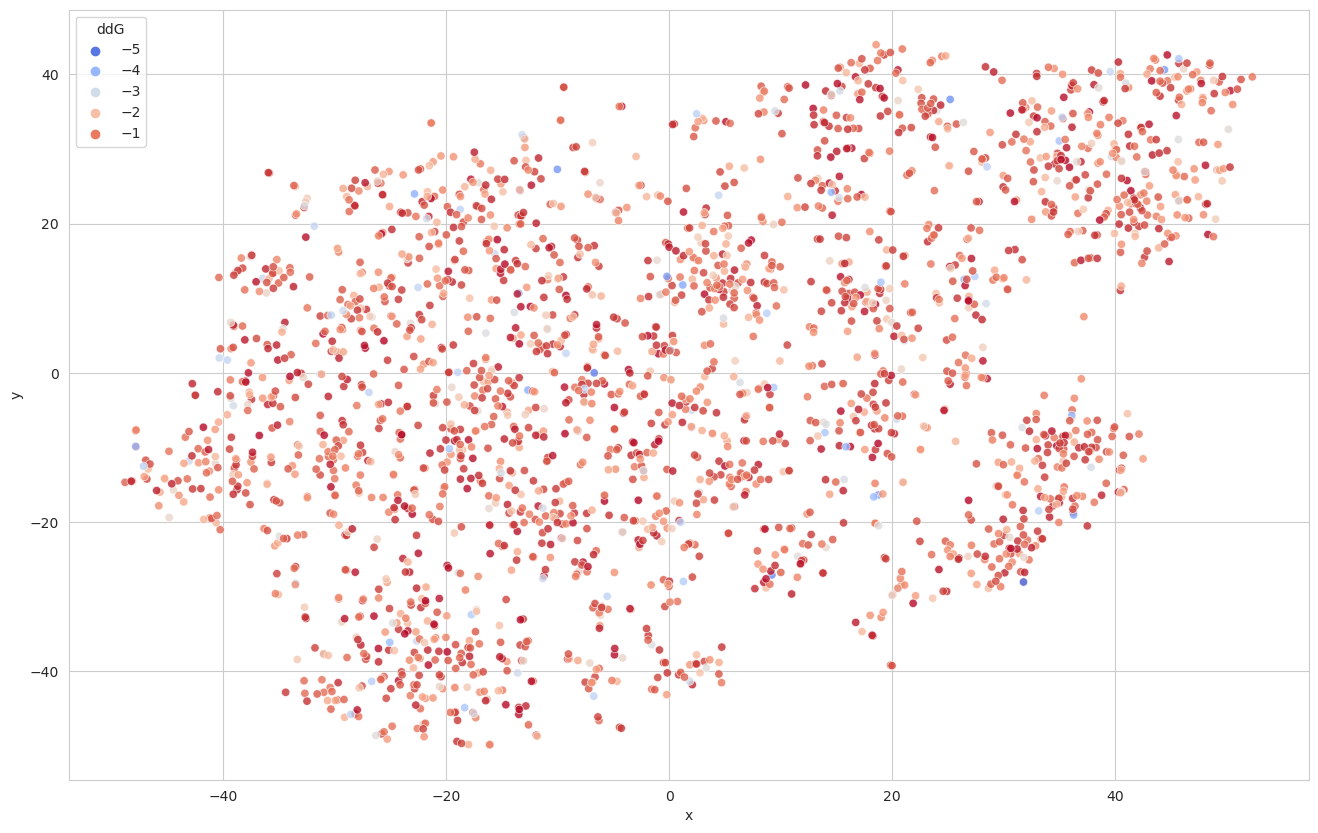

In [39]:
%%time
plt.figure(figsize=(16, 10))
sns.scatterplot(
    x="x", y="y",
    hue="ddG",
    palette='coolwarm',
    data=z_tsne,
    alpha=0.8
)

CPU times: user 59.7 ms, sys: 0 ns, total: 59.7 ms
Wall time: 58.4 ms


/home/hew/anaconda3/envs/deco/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/hew/anaconda3/envs/deco/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/hew/anaconda3/envs/deco/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


<Axes: xlabel='x', ylabel='y'>

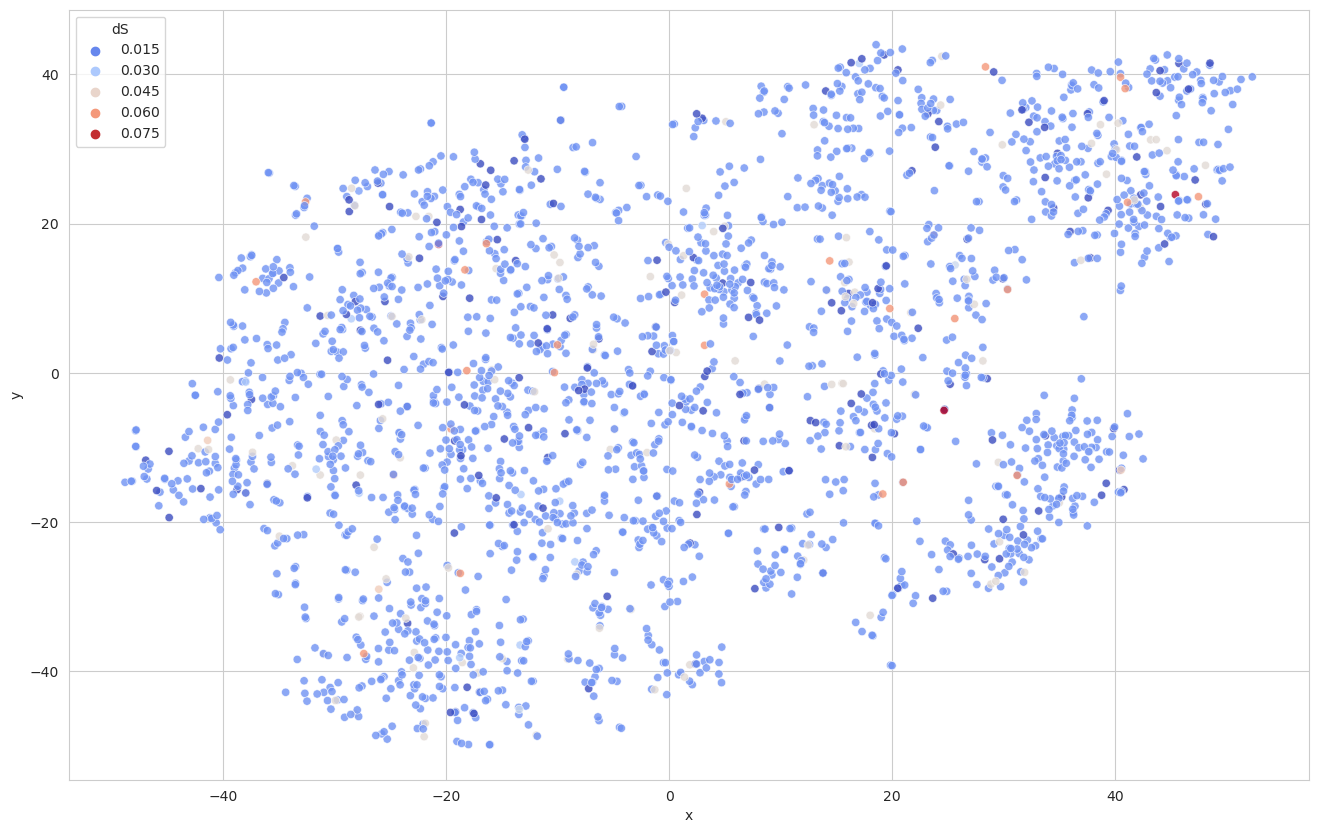

In [40]:
%%time
plt.figure(figsize=(16, 10))
sns.scatterplot(
    x="x", y="y",
    hue="dS",
    palette='coolwarm',
    data=z_tsne,
    alpha=0.8
)

CPU times: user 64.9 ms, sys: 3.46 ms, total: 68.4 ms
Wall time: 66.9 ms


/home/hew/anaconda3/envs/deco/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/hew/anaconda3/envs/deco/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/hew/anaconda3/envs/deco/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


<Axes: xlabel='x', ylabel='y'>

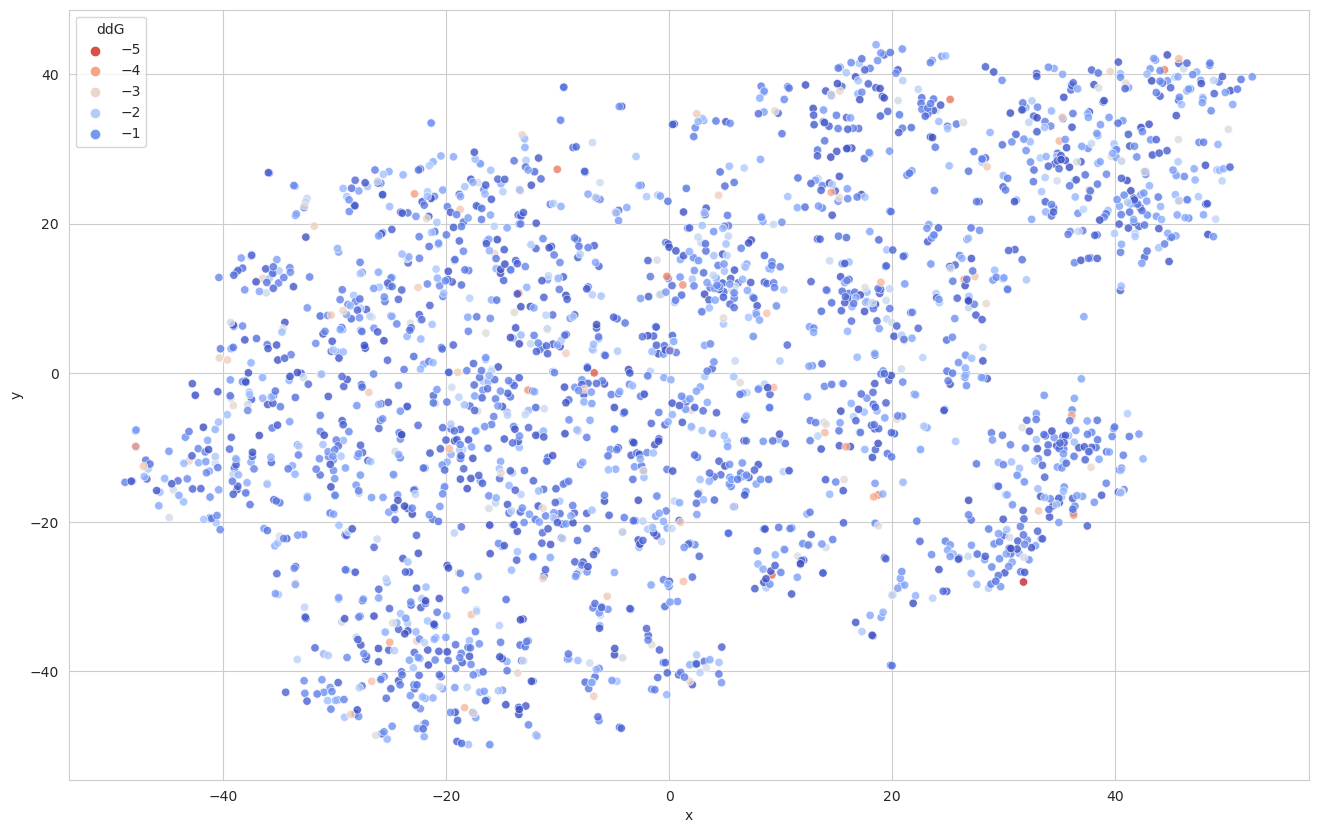

In [41]:
%%time
plt.figure(figsize=(16, 10))
sns.scatterplot(
    x="x", y="y",
    hue="ddG",
    palette='coolwarm_r',
    data=z_tsne[0 > z_tsne['ddG']][:3000],
    alpha=0.8
)

CPU times: user 45.3 ms, sys: 4.1 ms, total: 49.4 ms
Wall time: 48.4 ms


/home/hew/anaconda3/envs/deco/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/hew/anaconda3/envs/deco/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/hew/anaconda3/envs/deco/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


<Axes: xlabel='x', ylabel='y'>

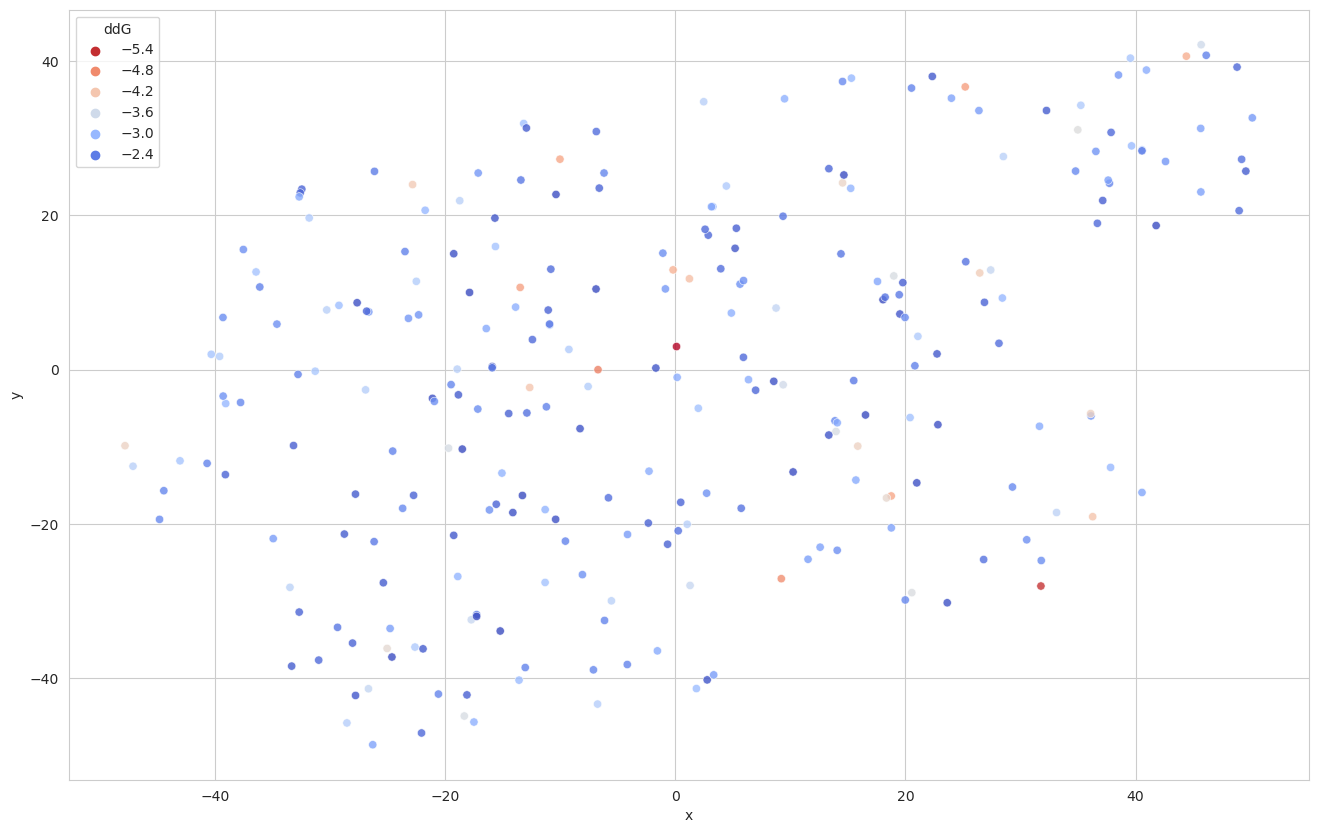

In [42]:
%%time
plt.figure(figsize=(16, 10))
sns.scatterplot(
    x="x", y="y",
    hue="ddG",
    palette='coolwarm_r',
    data=z_tsne[-2 > z_tsne['ddG']][:3000],
    alpha=0.8
)

CPU times: user 58.2 ms, sys: 8.16 ms, total: 66.3 ms
Wall time: 64.5 ms


/home/hew/anaconda3/envs/deco/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/hew/anaconda3/envs/deco/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/hew/anaconda3/envs/deco/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


<Axes: xlabel='x', ylabel='y'>

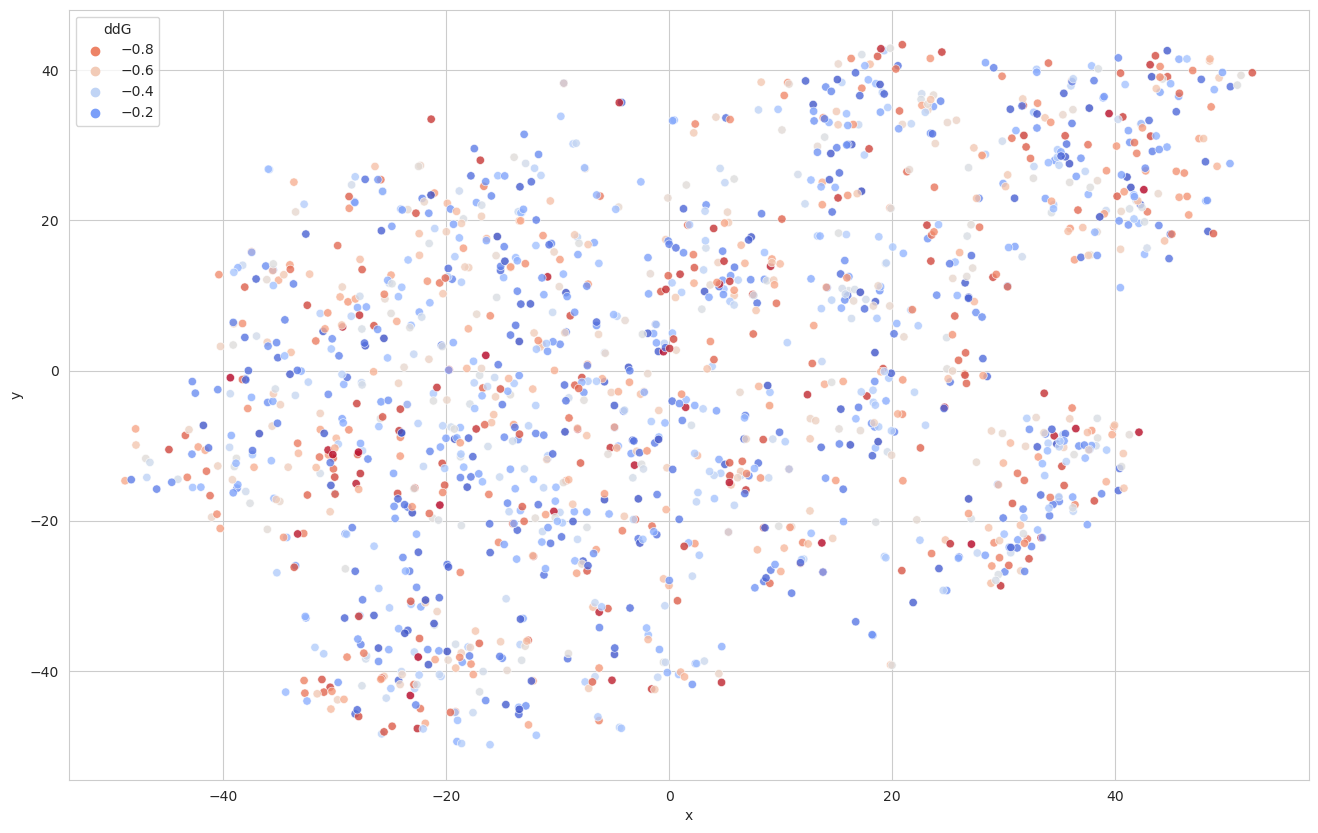

In [43]:
%%time
plt.figure(figsize=(16, 10))
sns.scatterplot(
    x="x", y="y",
    hue="ddG",
    palette='coolwarm_r',
    data=z_tsne[(1 > z_tsne['ddG']) & (-1 < z_tsne['ddG'])][:3000],
    alpha=0.8
)

In [44]:
z_norm = predict_z.norm(dim=1)
z_ddG = ddG
z_dS = dS

/home/hew/anaconda3/envs/deco/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/hew/anaconda3/envs/deco/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/hew/anaconda3/envs/deco/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


<Axes: xlabel='z_ddG', ylabel='z_dS'>

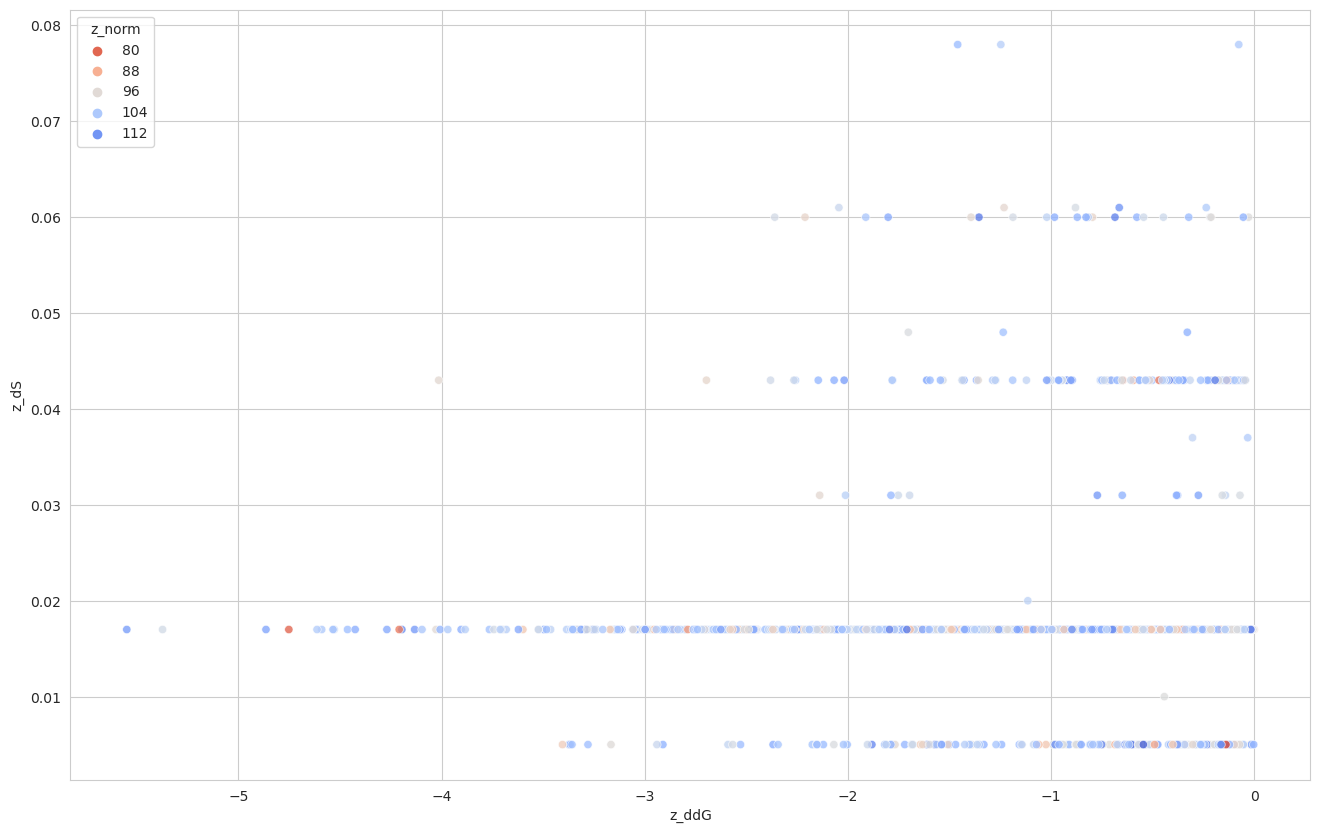

In [45]:
# 绘制z_norm与z_ddG和z_dS的关系
plt.figure(figsize=(16, 10))
sns.scatterplot(
    x="z_ddG",
    y="z_dS",
    hue="z_norm",
    palette='coolwarm_r',
    data=pd.DataFrame({'z_norm': z_norm, 'z_ddG': z_ddG, 'z_dS': z_dS}),
    alpha=0.8
)